# Basis Expansions and Regularization
Discusses "moving beyond linearity" &mdash; main idea is to augment in the input vector $X$ with some basis functions $h_{m}(X)$ that map $X$ to another input space. <br>In the new input space, we use linear models to model something like:

$f(X) = \sum_{m=1}^M \beta_{m}h_{m}(X)$

The chapter explores `piecewise polynomials` and `splines` to apply local polynomial representations of the data. 

The reason to do this is that polynomials tend to underfit since they're global models, but if you break down the problem, and fit locally, you can find a better solution

## Piecewise Polynomials and Splines
piecewise polynomial function is derived by splitting $X$ into contiguous intervals, and using different polynomilas to represent $f$ in each interval

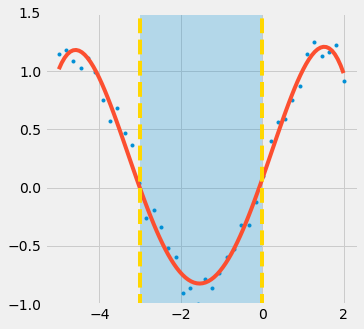

In [193]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# mimic examples in book
x = np.linspace(-5, 2, 40)
y = np.sin(x) + 0.3*np.random.rand(40)
fit = np.polyfit(x, y, deg=4)
p = np.poly1d(fit)
t = np.linspace(-5, 2, 100)

# draw knots
xi1 = -3; k1 = np.full(40, xi1)
xi2 = 0; k2 = np.full(40, xi2)

plt.figure(figsize=(5, 5));
plt.plot(x, y, '.', t, p(t), '-');
plt.plot(k1, x, '--', k2, x, '--', c="gold");
plt.axvspan(xi1, xi2, alpha=0.25);
plt.ylim(-1, 1.5);

spline `degrees of freedom` can be calculated by<br>
`(# of regions)(# of parameters in each region) - (# of knots)(# of constraints per knot)`

In [195]:
import numpy as np

path = "/Users/Ipanema/Google Drive/education/gatech/omsa/isye8803/homework/hw1/P04.csv"
data = np.genfromtxt(path, delimiter=',')
x = np.array(list(map(float, data[:, 0])))
y = data[:, 1]
x_min = x.min()
x_max = x.max()

In [196]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
loo.get_n_splits(x)

69

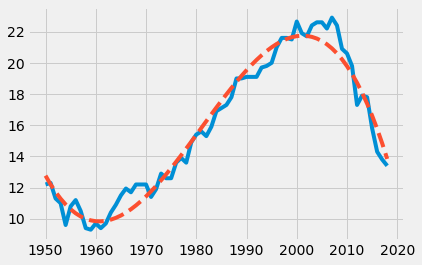

In [197]:
# find a global polynomial to fit the function
fit = np.polyfit(x, y, deg=3)
p = np.poly1d(fit)

plt.plot(x, y, '-', x, p(x), '--');

### Cubic Splines

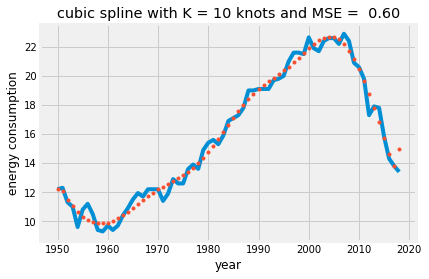

In [5]:
from scipy import interpolate
from sklearn.metrics import mean_squared_error

# iterate over number of knots
min_mse = 1e10
for k in range(6, 15):
    y_test = []
    y_hat = []
    
    for train_index, test_index in loo.split(x):
        x_train, y_train = x[train_index], y[train_index]
        x_test = x[test_index]
        y_test += list(y[test_index])
        
        k_i = np.linspace(1, len(x_train) - 2, k, dtype=int)
        knots = x_train[k_i]
        spl = interpolate.LSQUnivariateSpline(x_train, y_train, k=3, t=knots)
        y_hat += list(spl(x_test))
    
    # calculate MSE for current knot and keep track of the best
    mse = mean_squared_error(y_test, y_hat)
    if mse < min_mse:
        spl_best = spl
        min_mse = mse
    
plt.plot(x, y, '-', x, spl_best(x), '.')
plt.title("cubic spline with K = {0} knots and MSE = {1: 0.2f}".format(len(spl_best.get_knots()), min_mse))
plt.xlabel("year")
plt.ylabel("energy consumption");

### B-Splines

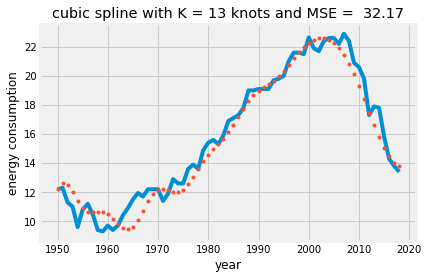

In [188]:
from scipy import signal
from patsy import dmatrix
import statsmodels.api as sm

min_mse = 1e10
for k in range(8, 15): 
    y_test = []
    y_hat = []
    
    for train_index, test_index in loo.split(x):
        x_train, y_train = x[train_index], y[train_index]
        x_test = x[test_index]
        y_test += list(y[test_index])
        
        k_i = np.linspace(1, len(x_train) - 2, k, dtype=int)
        knots = x_train[k_i]
        t_x = dmatrix("bs(x_train, knots=knots, degree=3, include_intercept=False)", 
                      {"x_train": x_train, "knots": knots}, return_type="dataframe")
        fit = sm.GLM(y_train, t_x).fit()
        
        pred = fit.predict(dmatrix("bs(age_grid, df=k, include_intercept=False)", 
                            {"age_grid": x_test, "knots": knots, "k": k+3}, return_type='dataframe'))
        y_hat += [pred]
        
    mse = mean_squared_error(y_test, y_hat)
    if mse < min_mse:
        k_best = k
        fit_best = fit 
        min_mse = mse
        
pred = fit_best.predict(dmatrix("bs(x, df=k, include_intercept=False)", 
                    {"x": x, "k": k_best+3}, return_type='dataframe'))        

plt.plot(x, y, '-', x, pred, '.')
plt.title("cubic spline with K = {0} knots and MSE = {1: 0.2f}".format(k_best, min_mse))
plt.xlabel("year")
plt.ylabel("energy consumption");        

### Smoothing Splines


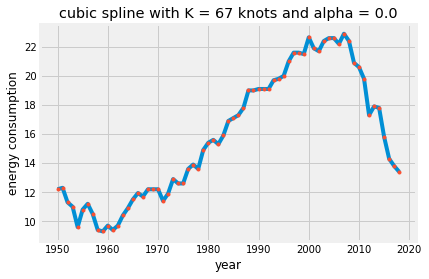

In [186]:
min_residual = 1e10
alpha = -1

for a in range(0, 100):
    k_i = np.linspace(1, len(x) - 2, k, dtype=int)
    knots = x[k_i]
    spl = interpolate.UnivariateSpline(x, y, k=3)
    spl.set_smoothing_factor(a/100.0)
    
    if spl.get_residual() < min_residual:
        spl_best = spl
        min_residual = spl.get_residual()
        alpha = a/100.0
                
knots_best = spl_best.get_knots()

plt.plot(x, y, '-', x, spl_best(x), '.')
plt.title("cubic spline with K = {0} knots and alpha = {1}".format(len(knots_best), alpha))
plt.xlabel("year")
plt.ylabel("energy consumption");

### Kernel Regression with Gaussian Kernel

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


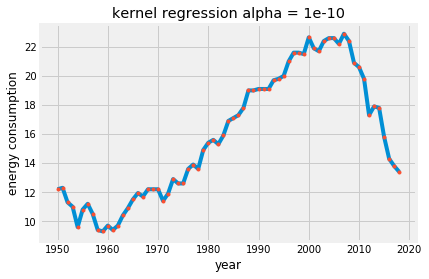

In [189]:
from sklearn import kernel_ridge
from sklearn import gaussian_process
from sklearn import model_selection

gpr = gaussian_process.GaussianProcessRegressor(random_state=42)
params = {
    "alpha": np.arange(1, 1e2) ** -2
}
gs = model_selection.GridSearchCV(gpr, params, cv=2)
gs.fit(x.reshape(-1, 1), y.reshape(-1, 1))
plt.plot(x, y, '-', x, gs.predict(x.reshape(-1, 1)), '.')
plt.title("kernel regression alpha = {0}".format(gs.get_params()['estimator__alpha']))
plt.xlabel("year")
plt.ylabel("energy consumption");

### B-Splines and FPCA

In [202]:
import pandas as pd
%matplotlib inline

train_path = "/Users/Ipanema/Google Drive/education/gatech/omsa/isye8803/homework/hw1/ECG200TRAIN"
test_path = "/Users/Ipanema/Google Drive/education/gatech/omsa/isye8803/homework/hw1/ECG200TEST"

df_train = pd.read_csv(train_path, header=None)
df_test = pd.read_csv(test_path, header=None)

y_train = df_train[0]
x_train = df_train.drop(0, axis=1)
y_test = df_test[0]
x_test = df_test.drop(0, axis=1)

In [216]:
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import classification_report
transformer = FactorAnalysis(1)
x_train_2 = transformer.fit_transform(x_train)
spl = interpolate.UnivariateSpline(x_train_2, y_train, k=3)
arr = spl(transformer.fit_transform(x_test))
y_hat = np.where(arr > 0, 1, -1)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

          -1       0.67      0.50      0.57        36
           1       0.75      0.86      0.80        64

   micro avg       0.73      0.73      0.73       100
   macro avg       0.71      0.68      0.69       100
weighted avg       0.72      0.73      0.72       100

